### MNIST-Fashion

Das [MNIST-Fashion dataset](https://github.com/zalandoresearch/fashion-mnist) besteht aus 70000 Bildern von Zalando-Artikeln.    Jedes Bild ist ein 28x28 schwarz-weiß Bild mit einem Label. Es gibt 10 verschiedene Klassen.
 

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
torch.set_printoptions(linewidth=120)

Import der Daten ins Unterverzeichnis *data*

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

Es gibt 60000 Trainingsbilder und 10000 Testbilder

In [3]:
len(train_set), len(test_set)

(60000, 10000)

Die verschiedenen Labels werden gezählt. Es gibt 10 verschiedenen Labels, die gleichverteilt sind.

In [4]:
train_set.targets.bincount(), test_set.targets.bincount()

(tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

#### Beispielbilder

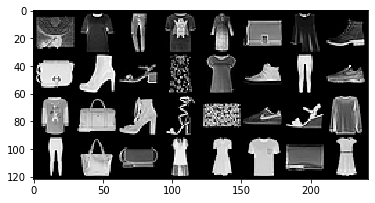

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

Ein *loader* stellt eine Teilmenge der Daten zur Verfügung

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=100)

#### Der Shape der Bilder

Mit *next(iter(train_loader))* laufen wir in Teilmengen durch die Gesamtdaten

In [7]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

Die 3. Dimension (also die 2. Zahl) wird als Farbkanal benutzt. Bei Schwarzweiß-Bildern sind hier nur die Grauwerte gespeichert.

<img src="img/nn-bildershape.png" width="900"> 

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):

        t = t.reshape(-1, 784)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.fc3(t)
        
        return t

Der letzte Layer hat keine Aktivierungsfunktion, weil die in der benutzten *Loss*-Funktion *cross-entropy* schon integriert ist.

In [9]:
%%time
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(2):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: 
        images, labels = batch 

        preds = net(images)  
        loss = F.cross_entropy(preds, labels) 

        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 48601 loss: 312.62201984226704
epoch 1 total_correct: 51318 loss: 237.91281020641327
Wall time: 24.1 s


Die Anzahl der Parameter in dem Netz:

<img src="img/nn-anzahlParameter.png" width="700"> 

In [10]:
zaehl = 0
for x in net.parameters():
    print(x.numel())
    zaehl += x.numel()
    
print("Gesamtanzahl Parameter: ", zaehl)

94080
120
7200
60
600
10
Gesamtanzahl Parameter:  102070


#### Anwenden auf Testdaten

In [11]:
correct = 0
for batch in test_loader:
    images, labels = batch 
    preds = net(images)
    correct += get_num_correct(preds,labels)
    
print("correct:",correct/len(test_set))

correct: 0.85


### Softmax

Die Sigmoid-Aktivierung nutzen wir, wenn wir zwei Klassen unterscheiden wollen (0,1). Die Softmax-Funktion nutzen wir als Aktivierungsfunktion für den letzten Layer bei mehr als 2 Klassen.

Wird ein neuronales Netz zur Klassifikation benutzt wird, dann nennt man den letzten Layer häufig den
**logits-layer**. Er produziert einen Vektor aus reellen Zahlen zwischen minus unendlich und plus unendlich, für jede Klassifikationklasse eine Zahl. Als Aktivierungsfunktion wird häufig die **softmax** -Funktion benutzt. Die Aufgabe der Softmax-Funktion ist es, den Vektor umzuwandeln in einen Vektor aus Wahrscheinlichkeiten dafür, dass die jeweilige Klasse erkannt wurde.

Beispiel: Punkte in der Ebene werden mit drei Farben gefärbt. Ein neuronales Netz soll die Farbe eines Punktes vorhersagen.

Der logits-Layer liefert für einen Input folgende Ausgabe:

In [12]:
logits = torch.tensor([[2, -1, 0.1]])

Je höher die Zahl, desto größer die Wahrscheinlichkeit, dass der Input zu der jeweiligen Klasse gehört.
Die softmax-Funktion rechnet die Werte in Wahrscheinlichkeiten um, d.h. in Zahlen zwischen 0 und 1, die sich zusammen zur 1 addieren.

In [13]:
torch.softmax(logits,dim=1)

tensor([[0.8338, 0.0415, 0.1247]])

Wie werden diese Zahlen berechnet? Da Wahrscheinlichkeiten immer positiv sind, werden zunächst alle drei Zahlen mit der e-Funktion in eine positive Zahl verwandelt.

In [14]:
import math
a = list(logits[0])
for x in a:
    print(math.exp(x))

7.38905609893065
0.36787944117144233
1.1051709197224806


Dann werden die Zahlen noch normiert, damit sie sich zu 1 aufsummieren.

In [15]:
import math
a = list(logits[0]) 
summe = sum([math.exp(x) for x in a])
for x in a:
    print(math.exp(x)/summe)

0.8337810127228958
0.04151151228426165
0.12470747499284246


Wenn wir mehrere Eingaben in einem Batch durch das Netz geschickt haben, enthält der logits-Layer Ausgaben für jedes Batch-Element. Die Softmax-Ausgabe erstellt für jeden Input einen Vektor mit den zugehörigen Wahrscheinlichkeiten. 

In [16]:
logits = torch.tensor([[2, -1, 0.1], [2.5,2,1.8]])
torch.softmax(logits,dim=1)

tensor([[0.8338, 0.0415, 0.1247],
        [0.4755, 0.2884, 0.2361]])

#### Cross Entropy Loss

Um den loss bei einer Klassifikation zu messen wird häufig die cross-entropy-Funktion benutzt. Nehmen wir an, wir berechnen wie oben die Färbung eines Punktes, der drei Farben annehmen kann, die wir mit 0, 1, 2 kodieren. 

In [17]:
target = torch.tensor([2])
logits = torch.tensor([[2,-1,0.1]])
loss = F.cross_entropy(logits, target)
loss

tensor(2.0818)

Wie wird diese Zahl berechnet? Die cross_entropy Funktion wendet zunächst die softmax-Funktion auf die logits an
(dies bedeutet, dass wir in der Definition unseres Netzes die Softmax-Funktion nicht als letzte Aktivierungfunktion
definieren müssen, wenn wir den loss  mit der cross_entropy Funktion messen)

In [18]:
sm = torch.softmax(logits,dim=1)
sm

tensor([[0.8338, 0.0415, 0.1247]])

Dann wird der Target-Wert in einen One-Hot-Vektor umgewandelt. Der One-Hot Vektor hat soviele Komponenten wie es Klassen gibt. Die Stelle mit der richtigen Klasse wird mit einer 1 belegt, alle anderen mit einer 0.

In [19]:
target = torch.tensor([[0,0,1.0]]) 

Dann wird das Skalarprodukt zwischen dem Softmax-Output und dem One-Hot-Vektor gebildet. Das Resultat ist die Wahrscheinlichkeit, die zur 1 gehört.

In [20]:
torch.mm(sm,target.T)

tensor([[0.1247]])

Dann wird der negative Logarithmus dieser Zahl gebildet

In [21]:
- torch.log(torch.mm(sm,target.T))

tensor([[2.0818]])

#### Cross Entropy Intuition

In unserem Beispiel ist der loss $-log(0.1247)$. $0.1247$ ist die Wahrscheinlichkeit, mit der der Algorithmus die korrekte Aussage belegt. Das Ziel des Algorithmus ist es, denn loss zu minimieren. Das geht nur dadurch, dass die Zahl innerhalb des $-log(..)$ größer wird. Die Zahl kann (als Wahrscheinlichkeit) natürlich nicht größer als 1 werden, aber auf alle Fälle wird ein Algorithmus, der versucht, den loss zu minimieren, das dadurch versuchen, diese Zahl der 1 zu nähern. Das bedeutet eine Bewegung in Richtung korrekter Klassifizierung.

<img src="img/nn-ln.png" width="500"> 

## Optimizer

#### Gradient Descent with Momentum

Die Lernrate bekommt in jede Richtung eine andere "Beschleunigung", je nachdem, wie die Durchschnittsgeschwindigkeit z.B. der letzten 10 Bewegungen war.

<img src="./img/optimizer01.png" width="400">

#### RMSprop

RMSprop (Root-Mean-Square Propagation) versucht wie Momentum, die Lernrate in den Richtungen, die nicht so eine einen hohe durchschnittliche Geschwindigkeit entwickeln, zu dämpfen. Bei der Implementation wird dabei ein Term mit einer Quadratwurzel benutzt.

#### Adam

Adam (Adaptive Momentum) verbindet Elemente von Gradient Descent with Momentum und RMSprop. Adam hat sich in vielen Anwendungsbeispielen als sehr gut herausgestellt.